# Consumer Behavior Analytics - Data Analysis (part 1)

**Libraries and imports**

In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# Utils
# import lux
# import itertools
import datetime

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Schedule
### Exploratory Data Analysis
- Feature Engineering: discretizing and combining some variables;
- Investigation on `AcceptedCmp`s variables;

Let's keep an easy access to the data dictonary:

<img src="../images/data_dict.jpg" width="600" height="300">

### 0. Loading dataset

In [2]:
ccustomers = pd.read_csv('../data/customers_cleaned.csv') # ccustomers: cleaned customers 
ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [3]:
ccustomers.shape

(2233, 27)

Since we will be using `Dt_Customer` for Feature Engineering, let's check the type of the date with `dtypes`.

In [4]:
ccustomers['Dt_Customer'].dtypes

dtype('O')

As an `object` (pandas way to say `str`) we won't be able to perform date operations. We need to transform it into a `datetime` object.

In [5]:
# Transforming Dt_Customer variable into a python datetime object
ccustomers['Dt_Customer'] = pd.to_datetime(ccustomers['Dt_Customer'])

We are all set. Let's mix some data.

## 1. Feature Engineering

**Feature Engineering** is a step usually performed during modelling. But, in some cases it can be useful also to analyze the data. 

At this stage, a meeting with the Business Intelligence department is hightly advisable because from them we can get a sense of the important metrics used to run the business. Since we are note able to contact them right now, we will move forward with creating a few variables that are direct combination from others.

**CAUTION!** At the modelling stage, this combination of variables could result in **multicolinearity** which is a typical machine learning problem:

>Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable. Other things being equal, the larger the standard error of a regression coefficient, the less likely it is that this coefficient will be statistically significant. [$_{ALLEN, \: M. \:The \:problem \:of \:multicollinearity. \:(1997)}$](https://link.springer.com/chapter/10.1007/978-0-585-25657-3_37)

We will have time to deal with possible multicolinearity in our dataset when modelling, right now, this new features can be usefull for a panoram view of customer's behaviour.

What more information can we get from out dataset? The list could be very long. For now let's focus on four of them:

- Generating `Family_Size`;
- Generating `Income_PerCap`;
- Generating `Prop_Spending_Income`;
- Generating `Avg_Ticket`; and
- Getting customers `Age` and storing into a new variable by itself.

We will explain in details by the time of creating each one of them.

Let's start:

### 1.1 Creating `Family_Size` variable and yearly `Income_PerCap` variable

Another interesting information would be calculating the income per capita of a household.

We would then get the `Income` (which represents the household income of a client per year) and divide by the total amount of people under the same roof.

We do not have this number yet, but we can achieve it with three other variables `Marital_Status`, `Kidhome` (which represents the number of small children in the household) and `Teenhome` (which represents the amount of teens).

For the `Marital_Status` varible, we can map categorical values to numbers:

* Married: `2` people;
* Together: `2` people;
* Single: `1` person;
* Divorced: `1` person;
* Widow: `1` person 

Finally, we can sum up the number of individuals in a household, save it as `Family_Size` variable and then calculate the `Income_PerCap`.

In [6]:
# Let's take a look of how many families has one of more children (Kid or Teen)
to_count_household = ['Kidhome', 'Teenhome']

for var in to_count_household:
    print(ccustomers[var].value_counts(), '\n============================ \n')

0    1288
1     897
2      48
Name: Kidhome, dtype: int64 

0    1154
1    1027
2      52
Name: Teenhome, dtype: int64 



Creating `Family_Size` variable:

In [7]:
ccustomers['Family_Size'] = ccustomers['Marital_Status'].map({'Married': 2, 
                                                              'Together': 2,
                                                              'Single': 1,
                                                              'Divorced': 1,
                                                              'Widow': 1}) + ccustomers['Kidhome'] \
                                                                           + ccustomers['Teenhome']

In [8]:
# Let's get income per capital per household per year

# Since we are not using the mapped Marital_Satus values yet, we are going to do it inline
ccustomers['Income_PerCap'] = round(ccustomers['Income'] / ccustomers['Family_Size'], 2) 

ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,3,15448.0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2,35806.5
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,3,8882.0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,3,19431.0


### 1.2 Creating the `Total_Spent` variable and the `Prop_Spending_Income` variable

Another interesting value to look at would be the proportion of spending a client (household) in regards to their Income. But we would run into a problem here. 

Since we are not sure if two adults are related, and therefore if they live under the same rood, we would be somehow miscounting the desired proportion.

A way to bypass this inconvenient would be calculating the proportion of spending in regards to their housedolf Income per Capita. 

In some cases, an individual with a family would have a relative larger proportion of spending in comparison to those who live alone. In some way, their interest for the products of the company would be magnified, and they could be potential buyes for the new device. But that is a conclusion only our future model will tell.

Let's calculate `Total_Spent` and `Prop_Spending_Income_pc`:

In [9]:
# Proportion of spending on company's products to Income and Income_PerCap

# Setting up Total $ spent per customer for all his/hers purchases
total_spent = np.sum(ccustomers[['MntWines', 
                                 'MntFruits',
                                 'MntMeatProducts', 
                                 'MntFishProducts', 
                                 'MntSweetProducts',
                                 'MntGoldProds']], axis = 1)

ccustomers['Total_Spent'] = total_spent

# Storing Proportion of spending in store and income
ccustomers['Prop_Spending_Income_pc'] = total_spent / ccustomers['Income_PerCap']

# Reviewing dataset
# ccustomers.head() # Uncomment for dataset view

### 1.3 Creating the  `Avg_Ticket` variable

Another metric to keep an eye on could be the Average Ticket of a customer in the store. Those with highter `avg_ticket`s could be more prone to spending more money on a single purchase, which could be the case of the device (even though we do not have information about how much the device costs).

In order to do so, we will use the `total_spent_per_customer` already calculated above and devide it by the total number o purchases a client has made in the companies selling channels.

At this point it is also important to point out that according to the Data Dictionary we have created the `total_spent_per_customer` values based on the purchase of goods in the **last two years**, while the total number of purchases will be calculated without the notion of time. This is going to generate a metric that requires some cautions:

1. We have to be caruful in cases of no record of purchases for a period we do not know, because that sum would ultimatly result in 0. Later, dividing the total amount spent by zero would skyrocket everything to infinity, a "number" models do not like, at all;
2. What is this metric's name? **Average Ticket of total amount spent in the last two year by total of purchases made in "I don't know how much time" period**. Not ideal.

Nonetheless, this could be usefull by our future model. **But as a recomendation, we should talk to the Data Analysis team to try to understand how this queries were perfomed, and maybe create a protocol so we can be sure that we would always be comparing apples to apples.**

Let's do so:

In [10]:
# First, let's get the total number of purchases per customer
total_purchases_per_customer = np.sum(ccustomers[['NumDealsPurchases', 
                                                  'NumWebPurchases',
                                                  'NumCatalogPurchases', 
                                                  'NumStorePurchases']], axis = 1)

ccustomers['Total_Puchases'] = total_purchases_per_customer

Before moving forward let's check if there are cases with `0` purhcases:

In [11]:
# Getting zero purchases in a unkown period of time
ccustomers[total_purchases_per_customer == 0]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases
652,5555,1975,Graduation,Divorced,153924.0,0,0,2014-02-07,81,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,153924.0,6,0.000039,0
978,3955,1965,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,0,1,4861.0,6,0.001234,0
1521,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,0,2,1751.0,5,0.002856,0
2129,11181,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,78462.0,8,0.000102,0


As imagined, there are customers with zero purchases.

Not weird enoght, these individuals have _spent_ an odd amount of money, such as MU \\$ 1 for wine products, MU \\$ 2 for meat products, etc.

Again, a conversation with Sales and Data Analys team would be welcome, so we can understant what this values really represent and if they are off or not.

Since we do not have detailed information of the companies products, we cannot evaluate this values as wrong, so we will move forwards as is, accepting they are right.


Let's compute the `Avg_Ticket` variable (with caution, replacign division by zero results for `-1`):

In [12]:
# Creating Average Ticket variable

#######################################
## With CAUTION with division by zero #
#######################################

# Calculating average ticket expense per customer
avg_ticket = round(total_spent / total_purchases_per_customer, 2)

# Dealing with customers with zero purchases, and replacing np.inf by -1
ccustomers['Avg_Ticket'] = np.where(avg_ticket == np.inf, -1, avg_ticket)

# Reviweing dataframe
ccustomers.head()

# Reviewing -1 cases
# ccustomers[ccustomers['Avg_Ticket'] == -1] # Uncomment for dataframe view

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.0,1617,0.027813,25,64.68
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,3,15448.0,27,0.001748,6,4.50
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2,35806.5,776,0.021672,21,36.95
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,3,8882.0,53,0.005967,8,6.62
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,3,19431.0,422,0.021718,19,22.21


### 1.4 Creating `Age` variable

In [13]:
ccustomers.shape

(2233, 33)

If we knew that the dataset was sampled in 2014 (the most recent date a customer become a client in our dataset, considering information from `Dt_Customer` variable) we could simply calculate:

\begin{align}
   2014 - \verb|Birth_Year|
\end{align}

But as for the information we have right now, we do not know when the dataset was sampled. Therefore we can't simply calcuate the difference between the dates.

**We need to determine when the dataset was sampled**, then.

The dataset, as instructed, is a _random sample_ of _hundreds of thousands_ of clients in the database, and our sample size, after cleaning, consists of 2,233 customers (which is an enourmous sample size if we want statisticly significant results).


<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> This is a great example of how basic things, that could've been solved with a phone call to the owner of the dataset, can get unnecessarily tricky and can get in the way of the <i>real</i> analysis, specially if we are considering a <b>deadline</b>. For this reason, I'll move forward with some assumptions but I've decided to supress all the mathematical bureocracy of testing.
</div>

Since our sample is big enough, and we are assuming that it is random, we expect to see that the sample distribution of customers entrance in the company at a time $t$ (month, week, day, etc.) follows the population distribution. 

For exemple, if the company has a constant growth rate of clients aquisition, then the clients entrance to the company has a Uniform distribution. In other words, if on avergage $x$ people becomes a customer in $t$ time, then we should expect that the last period $t$ is the one when the dataset was sampled. 

In order to get the sample distribution of clients entrance (without abandoning scientific rigour) we need to investigate the time span of our data.

**Getting data time span**

In [14]:
min_date, max_date = ccustomers['Dt_Customer'].min().strftime('%d-%m-%Y'), \
                            ccustomers['Dt_Customer'].dt.date.max().strftime('%d-%m-%Y')

print('First date in our sample dataset is: ', min_date)
print('Last  date in our sample dataset is: ', max_date)

# Calculating timespan from max_date and min_date
span_df_months = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) / np.timedelta64(1, 'M')
span_df_weeks = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) / np.timedelta64(1, 'W')

print(f'\nOur data spans throughout {np.ceil(span_df_months)} months (equivalent to {np.ceil(span_df_weeks)} weeks).')

First date in our sample dataset is:  30-07-2012
Last  date in our sample dataset is:  29-06-2014

Our data spans throughout 23.0 months (equivalent to 100.0 weeks).


In [15]:
# ccustomers['Marital_Status'].value_counts().plot(kind = 'bar')

In [16]:
# Create dataset with features of interest
age_analysis = ccustomers[['Year_Birth', 'Dt_Customer', 'Recency']]

# Parse dates to Year-Month
age_analysis['year_month'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%m')
age_analysis['year_week'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%V') # Caution working with weekly aggregations!

Weekly aggregations tend to get wild for weeks between years. Let's check:

In [17]:
# Looping to get wrong weekly aggregations indexes 
is_weeklyagg_broken = []
for year in [2012, 2013, 2014]:
    is_broken = age_analysis[(age_analysis['year_month'] == f'{year}-12') & \
                             (age_analysis['year_week'] == f'{year}-01')] # If month = 12, then week cannot = 01
    is_weeklyagg_broken.append(is_broken.index.values)
    
# Seing indexes of broken weekly agg data 
is_weeklyagg_broken = np.hstack(is_weeklyagg_broken).squeeze()
is_weeklyagg_broken

array([1691,   36,  477,  747,  924, 1199, 1373])

In [18]:
# Reviewing entries with broken weekly agg
# age_analysis.loc[is_weeklyagg_broken] # Uncomment for dataset view

In [19]:
# Changing values to its correct counterparts
age_analysis['year_week'].iloc[is_weeklyagg_broken] = \
        age_analysis['year_week'].iloc[is_weeklyagg_broken].map({'2012-01': '2012-52', '2013-01': '2013-52'})

# Reviwing after change
# age_analysis.loc[is_weeklyagg_broken] # Uncomment for dataset view

Now that all date entries are correct, let's group them by `year_month` and `year_week`. These grouping will be necessary for checking clients' entrance distribution.

In [20]:
# Group data by Year-Month and by Year-Week
age_analysis_grouped_month_year = age_analysis.groupby(by = 'year_month').count()
age_analysis_grouped_week_year = age_analysis.groupby(by = 'year_week').count()

**Let's plot both `year_month` and `year_week` distributions:**

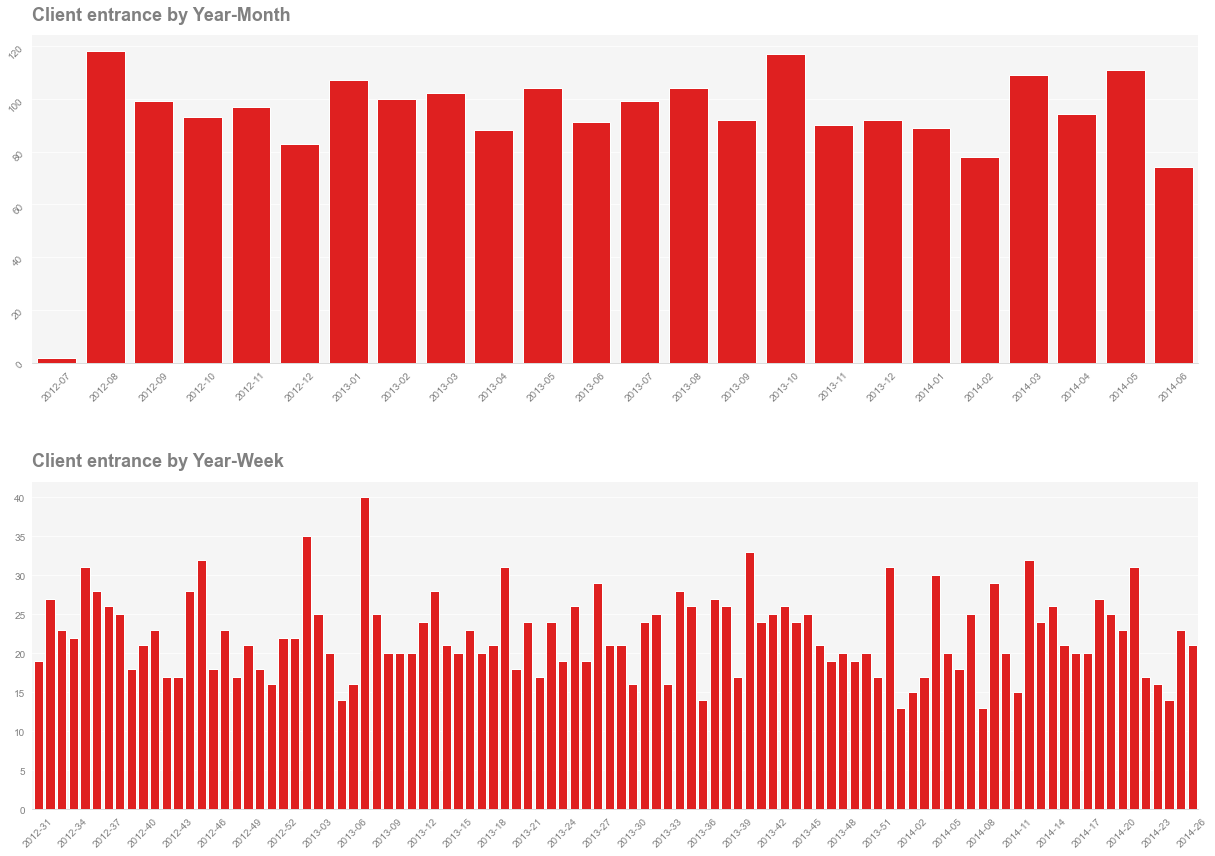

In [21]:
# Setting up plots
sns.set_style("darkgrid", rc = {'axes.facecolor':'whitesmoke'})
fig, ax = plt.subplots(2, 1, figsize = (17, 12))
sns.despine(top = True, left = True)

# Plot Year-Month Distribution
sns.barplot(x = age_analysis_grouped_month_year.index, 
            y = age_analysis_grouped_month_year['Year_Birth'], 
            ax = ax[0], 
            color = 'red')
ax[0].set(ylabel = None, xlabel = None)
ax[0].set_title('Client entrance by Year-Month', loc = 'left', size = 18, 
                pad = 15, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray', rotation = 45)

# Plot Year-Year_week Distribution
sns.barplot(x = age_analysis_grouped_week_year.index, 
            y = age_analysis_grouped_week_year['Year_Birth'], 
            ax = ax[1],
            color = 'red')
ax[1].set_title('Client entrance by Year-Week',  loc = 'left', size = 18, 
                pad = 15, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[1].set(ylabel = None, xlabel = None)
ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
plt.xticks(np.arange(0, len(age_analysis_grouped_week_year.index), step = 3), 
           rotation = 45)

plt.tight_layout(h_pad = 5);

As imagined, the aggregated data follows an Uniform distribution. If the company hasn't compromised itself in a _really bad way_ to the eyes of the public, and knowing it hasn't closed its doors (otherwise we probably wouldn't be working on this analysis), by the following months, we should expect that the numbers of customers joining the company as a client to be arround average of client entrances in the previous months. 

Straghtfowardly, it is highly unlikelly that no new person became a company's client after june 2014.

How's so?

If the sample is randon and the company is not seriously comprimised, and having a sample with 2,233 individuals, the probability of **not selecting a single one** of them who would've entered the data after june 2014 when sampling is really, really low.

In fact, we can say with $99 \%$ confidence (and margin of error of $\approx 2.7 \%$) that this sample would represent the actual population parameters, considering a population of $999,999$ individuals (the maximum in _hundreds of thousands_ as described in the guidelines of this project). As a reference, we can check the image below, from [Suvey Monkey's Sample Size Calculator](https://www.surveymonkey.com/mp/sample-size-calculator/).

<img src="../images/survey_monkey.jpg" width="800" height="400">

### **But...**

Before moving forward to set 2014 as the date the dataset was sampled, and then compute the age of the customers, there's still one piece of this puzzle which is outstanding and could be used for an integrity checkup.

The variable `Recency`, as described in our data dictionary, is the amount of days since a customer's last purchase. In theory, with our previous assumptions made, we should not have a client that entered in June 2014, having a purchased something several days before our dataset being sampled.

Let's check:

In [22]:
ccustomers[ccustomers['Recency'] == ccustomers['Recency'].max()].sort_values('Dt_Customer', ascending = False).head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket
1797,2831,1976,Graduation,Together,78416.0,0,1,2014-06-27,99,453,38,279,188,38,183,2,7,7,10,3,0,0,0,0,0,0,0,3,26138.67,1179,0.045106,26,45.35


The customer with `ID` #2831 joined the the company as a client in June 2014 and his/hers last purchase was 99 days before the sampling!


<div class="alert alert-block alert-danger">
This is a huge compromise for the statistical analysis we just performed. Mainly, because we've statistcly proved that, everything kept constant, customers kept joining the company and none of them being select just means that our sample dataset <b>was not random <i>at all</i></b>.
</div>

Maybe, for some unkown reason, clients who've joined the company after June 2014 would be more propense to buy the device. Unfortunatelly, we won't be able to study this fenomena and therefore our analysis, and, by the way, our modeling, is enclosed in the time span of our sampling.

The results of our future model just gained a prefix introduction:

>— **_For clients who've joined the company until June 2014_** our model's performance is xxx.

Obviously, at some extent the model might be able to classify pretty well the _persona_ of those customer's who might be interested in purchasing the device, even for those who joined after June 2014. But it may as well go really bad, for these customers, when the model is in production. We cannot say, because we do not have the data to analyze.

At this point of the analysis, I would suggest a meeting with Research and Experiment Design department so everyone can be on the same page regarding what is random sampling and what are the implications when these conditions are not met.

In [23]:
ccustomers['Dt_Customer'].max()

Timestamp('2014-06-29 00:00:00')

#### (Finally) Let's calculate `Age`

Since we could not determine the date the dataset was generated, let's arbitrarly choose 2014 as the age of the dataset. $June \: 29^{th}, \: 2014 \: + \: 99 \: days$ would be still year 2014 and this is the closest information we have about a possible date of the dataset date cut. 

In [24]:
# Creating Age variable
ccustomers['Age'] = 2014 - ccustomers['Year_Birth']

# Reviewing dataset with Age variable
ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.0,1617,0.027813,25,64.68,57
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,3,15448.0,27,0.001748,6,4.50,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2,35806.5,776,0.021672,21,36.95,49
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,3,8882.0,53,0.005967,8,6.62,30
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,3,19431.0,422,0.021718,19,22.21,33


In [25]:
# sns.distplot(ccustomers['Age'], color = 'red');

------------------

## 2. Investigation on `AcceptedCmp`s variables

Bearing in mind that the marketing was made by phone calls, according to the Data Dictornary the five `AcceptedCmpX` variables are:

> 1 if customer accepeted the offer in the $X^{th}$ campaign, 0 otherwise, for $X$ from 1 to 5 campaigns.

There is also the _target_ variable `Response`, which is:

> 1 if customer accepeted the offer in the last campaign, 0 otherwise.

Since we do not have access to the responsibles for the design of this experiment, we need to understand clearly what these variables mean by ourselves. The two most plausible hypothesis are:

- A customer which accepted the offer in any of the campaigns has value `1` in the target variable `Response`;
- "Accepeted the offer" means answering the phone call and listening to the seller's offer, not necessarily buying it, imediately or later (`0` in `Response`).

Let's investigate each one of these hypoteshis:

### i. A customer which accepted the offer in any of the campaigns has value `1` in the target variable `Response`

In [26]:
purchase_flow = ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]

purchase_flow['total'] = np.sum(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']], axis = 1)

ccustomers[(purchase_flow['total'] >= 1) & (ccustomers['Response'] == 0)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,4,1412.00,49,0.034703,2,24.50,64
18,6565,1949,Master,Married,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,3,25665.00,1782,0.069433,26,68.54,65
22,1993,1949,PhD,Married,58607.0,0,1,2012-12-23,63,867,0,86,0,0,19,3,2,3,9,8,0,1,0,0,0,0,0,3,19535.67,972,0.049755,17,57.18,65
29,1966,1965,PhD,Married,84618.0,0,0,2013-11-22,96,684,100,801,21,66,0,1,6,9,10,2,0,0,1,0,0,0,0,2,42309.00,1672,0.039519,26,64.31,49
32,5710,1970,Graduation,Together,40548.0,0,1,2012-10-10,31,110,0,5,2,0,3,2,2,1,4,5,0,1,0,0,0,0,0,3,13516.00,120,0.008878,9,13.33,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,4286,1970,PhD,Single,57642.0,0,1,2014-01-09,24,580,6,58,8,0,27,3,7,6,6,4,1,0,0,0,0,0,0,2,28821.00,679,0.023559,22,30.86,44
2222,8720,1978,2n Cycle,Together,77423.0,0,0,2012-08-12,53,32,2,1607,12,4,22,0,0,0,1,0,0,1,0,0,0,0,0,2,38711.50,1679,0.043372,1,1679.00,36
2224,7004,1984,Graduation,Single,11012.0,1,0,2013-03-16,82,24,3,26,7,1,23,3,3,1,2,9,1,0,0,0,0,0,0,2,5506.00,84,0.015256,9,9.33,30
2229,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,5,12802.80,444,0.034680,22,20.18,68


**No**, accepting a campaign does not mean that the consumer responded `1` in `Response`, our target variable.

Which leads us to our second hypoteshis:

### ii. "Accepeted the offer" means answering the phone call and listening to the seller's offer

Basically, the same analysis for the previous hipothesis can be taken into account here, as long as we build upon it with one other analysis.

- A customer's being contacted (and having answered the phone call) in any of the campaigns (`1` in **any** of the `AcceptedCmpX` varibales) does not imply buying the device. That is, `0` in `Response`;

- If the marketing was conducted only by phone calls, then customers who did not answered the phone (`0` in **all** of the five `AcceptedCmpX`) did not know about the existence of the device and therefore did not buy it (`0` in Response);

The first one we already know, from previous analysis, it's `TRUE`.

Let's test the second one:

In [27]:
np.logical_and(purchase_flow['total'] == 0,
               ccustomers['Response'] == 0).all()

False

In [28]:
ccustomers[(purchase_flow['total'] == 0) & (ccustomers['Response'] == 1)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.00,1617,0.027813,25,64.68,57
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,3,10117.00,46,0.004547,6,7.67,40
33,7373,1952,PhD,Divorced,46610.0,0,2,2012-10-29,8,96,12,96,33,22,43,6,4,1,6,6,0,0,0,0,0,0,1,3,15536.67,302,0.019438,17,17.76,62
46,9909,1996,2n Cycle,Married,7500.0,0,0,2012-11-09,24,3,18,14,15,22,50,3,3,1,3,9,0,0,0,0,0,0,1,2,3750.00,122,0.032533,10,12.20,18
56,10383,1966,Graduation,Divorced,70287.0,0,0,2013-04-02,30,295,35,482,121,120,40,1,5,5,10,3,0,0,0,0,0,0,1,1,70287.00,1093,0.015551,21,52.05,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,1631,1965,PhD,Together,65220.0,0,0,2012-09-03,3,890,63,292,0,25,12,4,8,4,7,6,0,0,0,0,0,0,1,2,32610.00,1282,0.039313,23,55.74,49
2135,2715,1966,Master,Divorced,29435.0,1,1,2012-08-06,11,70,3,37,4,2,64,4,3,2,2,9,0,0,0,0,0,0,1,3,9811.67,180,0.018346,11,16.36,48
2156,5667,1964,PhD,Married,60896.0,0,1,2012-10-11,90,1013,30,399,60,46,153,3,9,10,4,6,0,0,0,0,0,0,1,3,20298.67,1701,0.083799,26,65.42,50
2185,4418,1983,Master,Single,89616.0,0,0,2013-02-25,36,671,47,655,145,111,15,1,7,5,12,2,0,0,0,0,0,0,1,1,89616.00,1644,0.018345,25,65.76,31


**Second hypothesis does not hold either.**

Mainly because `Response`, as the data dictornary suggests, is also a phone call promoting the device. So if the seller succeded in contacting the customer by phone in the sixth campaign (that would be `Response`) he/she may have still baught it.

The target variable seems to have double meaning. It could be any of these cases:
- The customer did not answered the phone, and therefore did not buy the device;
- The customer answered the phone, and bought the device;
- (And the most problematic one) The customer answered the phone and did not buy the product.

The third case does not comply with booleans values because it would be `0` $and$ `1` at the same time. (And if you guys allow me the joke, Schrodinger sent 'Hello' 🐈)

We could also try to hypothesize that people with more exposure to the campaigns are more prone to having baught the device. In this case there would be a positive correlation total call accepted and `Response` equals `1`. But at the beggining this analysis does not hold either.

Let's check why:

In [29]:
# Customers who were not exposed to the marketing in the first campaigns but bought the device in the last one
last_cmp_1s = ccustomers[(purchase_flow['total'] == 0) & (ccustomers['Response'] == 1)].shape[0]

last_cmp_1s_pct_of_total_1s = last_cmp_1s / ccustomers[ccustomers['Response'] == 1].shape[0] * 100

print("Customers who bought the device having responded only to the last campaign: ", last_cmp_1s)
print("% Percentage of total 1s:                                                    ", 
      round(last_cmp_1s_pct_of_total_1s, 2), "%")

Customers who bought the device having responded only to the last campaign:  145
% Percentage of total 1s:                                                     43.54 %


More than $40 \%$ of customers sampled answered the phone only in the last campaign and immediatelly baught it, compromising any chance of a "more exposure, more buying" hypothesis.

We do not know _for sure_ the meaning of the `AcceptedCmpX` variables, so we will accept the "the customer bought the product if and only if he is marked as `1` in `Response`.

We could delete this variables, but let's see how the algorithms responds to them by the time of modelling.

Finally, before moving forward another **suggestion**: a meeting with the Data and Design of Experiment departments to understand what this variables means and debate about the importance of non-ambiguous definitions. 🐈‍⬛

## Paradigm shift: Exposed and Not-Exposed customers

Although we could not fully determine the meaning of `AcceptedCmpX` variables in the previous analysis, one very important question popped up:

>**How could we model customer's as non-reponding to the campaign if they haven't been aware of the campaign (or the campaign content?**

In the case we are considering customers as non-respondents to the campaign (`Response` = `0`), we are introducing a huge ammount of noise to the analysis, specially by the time of modelling.

Our ambiguous values in the `Response` variable, as observed previously, turns out to be pretty important to the task of modelling who must be the customer's target when selling the device.

Some decisions must be made.

In order to proceed, we should fork into two analysis and modelling:

1. Considering the whole dataset;
2. Considering only the customers who we know have been somehow exposed to the campaign (those with `1` in any of the `AcceptedCpmX` variables).

We will model the two of them separatelly and check if the results are any different before adising for the best model.

Let's create the `customers_exposed` dataset then:

In [30]:
# Filtering index of customers who haven't been exposed to the campaign
not_exposed_idx = ccustomers[(purchase_flow['total'] == 0) & (ccustomers['Response'] == 0)].index

# Creating a dataset of customers who haven't been exposed
ccustomers_not_exposed = ccustomers.index.isin(not_exposed_idx)

# Creating a dtaset of interest: customers who were exposed to the campaign
ccustomers_exposed = ccustomers[~ccustomers_not_exposed]

# Taking a look at df of interest
ccustomers_exposed.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.0,1617,0.027813,25,64.68,57
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,3,10117.0,46,0.004547,6,7.67,40
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,4,1412.0,49,0.034703,2,24.50,64
15,2114,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,1,82800.0,1315,0.015882,26,50.58,68
18,6565,1949,Master,Married,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,3,25665.0,1782,0.069433,26,68.54,65


In [31]:
# Checking ccustomers_exposed shape
ccustomers_exposed.shape

(607, 34)

And now, we can check how balanced the dataset is regardint the target variable `Response`:

In [32]:
# Checking ccustomers_exposed dataset balance for target variable Response
print(ccustomers_exposed['Response'].value_counts(), '\n')
print(ccustomers_exposed['Response'].value_counts(normalize = True))

1    333
0    274
Name: Response, dtype: int64 

1    0.5486
0    0.4514
Name: Response, dtype: float64


That is what is called a paradigm shift!

$331$ customer's out of $607$, almost $55\%$ of those who accepted the campaign, baught the device.

**We now have a slightly unballanced dataset towards customer's who baught the device!**

If we consider these values, metrics are all different: the success rate of the campaign among those who answerd the phone is much bigger.

Let's sabe the two datasets (the `customers_whole` dataset and the `customers_exposed`) into new csv files and move forward with our analysis, but in parallel.

And we may need different notebooks for each one of them, so things don't get messed up in the middle.

In [33]:
ccustomers.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,5589.354680,1968.899687,51923.900582,0.444693,0.506494,49.158083,304.140170,26.278549,166.939095,37.493954,27.114196,43.931482,2.323332,4.085535,2.663681,5.795343,5.317958,0.072996,0.074787,0.072548,0.064487,0.013435,0.008957,0.149127,2.596955,24839.597873,605.897447,0.022924,14.867891,33.258133,45.100313
std,3242.988776,11.707791,21485.048058,0.538575,0.544669,28.943797,336.814778,39.735239,225.704069,54.569126,41.316973,52.035539,1.932619,2.780393,2.925021,3.253305,2.426172,0.260188,0.263107,0.259451,0.245674,0.115153,0.094235,0.356293,0.907273,19459.964188,602.126936,0.048145,7.681905,45.028130,11.707791
min,0.000000,1940.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,815.670000,5.000000,0.000039,0.000000,-1.000000,18.000000
25%,2829.000000,1959.000000,35246.000000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12100.330000,69.000000,0.006448,8.000000,9.600000,37.000000
50%,5455.000000,1970.000000,51315.000000,0.000000,0.000000,50.000000,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,18586.330000,396.000000,0.017562,15.000000,23.380000,44.000000
75%,8420.000000,1977.000000,68397.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,31927.500000,1045.000000,0.034051,21.000000,45.220000,55.000000
max,11191.000000,1996.000000,162397.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,153924.000000,2525.000000,2.120956,44.000000,1679.000000,74.000000


In [36]:
# idx_to_drop_meatproducts = ccustomers[ccustomers['MntMeatProducts'] == ccustomers['MntMeatProducts'].max()].index
# ccustomers.drop(idx_to_drop_meatproducts).describe()

In [37]:
# ccustomers.describe()

In [38]:
# Saving customers_whole into a new csv file
ccustomers.to_csv('../data/customers_whole.csv', index = False) # Uncomment to save csv file

In [39]:
# Saving customers_exposed into a new csv file
ccustomers_exposed.to_csv('../data/customers_exposed.csv', index = False) # Uncomment to save csv file

<!-- We will continue with **Univariate** and **Bivariate** Analysis in the next notebooks. -->

------------------

In [40]:
############# DRAFTS

In [ ]:
# numeric_features = ccustomers.drop(['ID', 'Year_Birth'], axis = 1).select_dtypes('number').columns.tolist()
# len(numeric_features)

In [ ]:
# ccustomers_1s = ccustomers[ccustomers['Response'] == 1]
# ccustomers_0s = ccustomers[ccustomers['Response'] == 0]

In [ ]:
# ccustomers_1s.sample(30, replace = True)

In [ ]:
# # Create the data
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[])
# g.despine(bottom=True, left=True);

In [ ]:
# to_count_AccCmp = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
# for var in to_count_AccCmp:
#     print(ccustomers[var].value_counts(), '\n================================ \n')

In [ ]:
# ccustomers[ccustomers['Dt_Customer'] == ccustomers['Dt_Customer'].min()]

In [ ]:
# to_count = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
# for var in to_count:
#     print(ccustomers[var].value_counts(), '\n================================ \n')

In [ ]:
# purchase_flow = ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]
# purchase_flow['total'] = np.sum(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']], axis = 1)
# # np.sum(np.array(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]), axis = 1)
# ccustomers[purchase_flow['total'] == 5]

In [ ]:
# ccustomers['Recency'].hist();

In [ ]:
# ccustomers['Response'].value_counts()

In [ ]:
# ccustomers[ccustomers['Response'] == 1]['Recency'].hist()
# ccustomers[ccustomers['Response'] == 0]['Recency'].hist()